In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Verify you can see your files
# This should print the list of disease folders
!ls "/content/drive/MyDrive/DeepRice_Project/rice_data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Bacterial leaf blight'  'Brown spot'  'Leaf smut'


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define the path (Adjust if your folder name is different)
data_dir = '/content/drive/MyDrive/DeepRice_Project/rice_data'

# The Transformers
transform = transforms.Compose([
    transforms.Resize((128, 128)),       # Uniform size
    transforms.RandomRotation(15),       # Augmentation
    transforms.RandomHorizontalFlip(),   # Augmentation
    transforms.ToTensor(),               # Convert to 0-1 numbers
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load Data
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split 80% Train / 20% Test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_data, test_data = random_split(full_dataset, [train_size, test_size])

# Create Loaders (The conveyer belt that feeds data to the GPU)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Total Images: {len(full_dataset)}")
print(f"Classes: {full_dataset.classes}")

Total Images: 120
Classes: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class RiceNet(nn.Module):
    def __init__(self, num_classes):
        super(RiceNet, self).__init__()

        # Block 1: Input (3 channels) -> 32 Filters
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Block 2: 32 -> 64 Filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Block 3: 64 -> 128 Filters
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Fully Connected Layer calculation:
        # Image starts at 128x128.
        # After 3 pooling layers (divided by 2 three times): 128 -> 64 -> 32 -> 16.
        # So final size is 16x16 with 128 channels.
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16) # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RiceNet(num_classes=len(full_dataset.classes)).to(device)
print(model)

RiceNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 40 # Can increase to 50 if accuracy is low

print("Starting Training...")
for epoch in range(epochs):
    model.train() # Set mode to training
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f}")

print("Training Complete.")

Starting Training...
Epoch 1/40 - Loss: 1.3778
Epoch 2/40 - Loss: 1.1214
Epoch 3/40 - Loss: 1.0055
Epoch 4/40 - Loss: 0.9279
Epoch 5/40 - Loss: 0.8697
Epoch 6/40 - Loss: 0.8337
Epoch 7/40 - Loss: 0.8632
Epoch 8/40 - Loss: 0.7235
Epoch 9/40 - Loss: 0.8057
Epoch 10/40 - Loss: 0.6980
Epoch 11/40 - Loss: 0.7054
Epoch 12/40 - Loss: 0.6340
Epoch 13/40 - Loss: 0.6262
Epoch 14/40 - Loss: 0.6118
Epoch 15/40 - Loss: 0.4992
Epoch 16/40 - Loss: 0.5070
Epoch 17/40 - Loss: 0.5061
Epoch 18/40 - Loss: 0.4390
Epoch 19/40 - Loss: 0.3827
Epoch 20/40 - Loss: 0.4045
Epoch 21/40 - Loss: 0.3553
Epoch 22/40 - Loss: 0.3344
Epoch 23/40 - Loss: 0.4102
Epoch 24/40 - Loss: 0.3446
Epoch 25/40 - Loss: 0.3169
Epoch 26/40 - Loss: 0.3190
Epoch 27/40 - Loss: 0.3012
Epoch 28/40 - Loss: 0.2262
Epoch 29/40 - Loss: 0.2010
Epoch 30/40 - Loss: 0.1809
Epoch 31/40 - Loss: 0.1879
Epoch 32/40 - Loss: 0.1613
Epoch 33/40 - Loss: 0.1609
Epoch 34/40 - Loss: 0.1644
Epoch 35/40 - Loss: 0.1957
Epoch 36/40 - Loss: 0.1811
Epoch 37/40 - Lo

In [ ]:
# Save the trained model to Drive so you don't lose it
torch.save(model.state_dict(), '/content/drive/MyDrive/DeepRice_Project/rice_model.pth')

# Check Accuracy
correct = 0
total = 0
model.eval() # Set mode to evaluation (turns off dropout)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network: {100 * correct / total:.2f}%')

Accuracy of the network: 75.00%


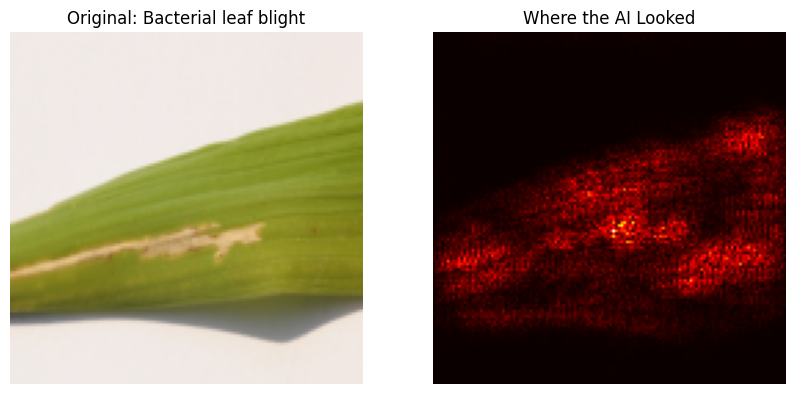

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def get_saliency_map(model, image, label):
    # 1. Set model to eval mode but enable gradients for the image
    model.eval()
    image.requires_grad_()

    # 2. Forward pass
    output = model(image.unsqueeze(0).to(device))

    # 3. Catch the score for the correct class
    score = output[0][label]

    # 4. Backward pass to get gradients
    score.backward()

    # 5. Get the maximum gradient across color channels (R, G, B)
    # This tells us which pixel changed the output the most
    saliency, _ = torch.max(image.grad.data.abs(), dim=0)

    return saliency

# --- VISUALIZATION LOOP ---
# Get a random batch of images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Pick the first image in the batch
idx = 0
img = images[idx]
lbl = labels[idx]

# Generate heatmap
saliency = get_saliency_map(model, img, lbl)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Original Image (Un-normalize to make it look like a photo again)
img_np = img.cpu().detach().numpy().transpose(1, 2, 0)
img_np = img_np * 0.5 + 0.5 # Reverse the normalization
ax[0].imshow(img_np)
ax[0].set_title(f"Original: {full_dataset.classes[lbl]}")
ax[0].axis('off')

# Saliency Map (The "Brain Scan")
ax[1].imshow(saliency.cpu(), cmap='hot')
ax[1].set_title("Where the AI Looked")
ax[1].axis('off')

plt.show()

In [ ]:
from PIL import Image

def predict_custom_image(image_path, model):
    # 1. Load the image
    img = Image.open(image_path)

    # 2. Preprocess (Must be same as training!)
    # We need a transformation specifically for single images (no augmentation)
    pred_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    img_tensor = pred_transform(img).unsqueeze(0).to(device) # Add batch dimension

    # 3. Predict
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)

        # Calculate percentages (Softmax)
        probs = torch.nn.functional.softmax(output, dim=1)
        top_prob, top_class = probs.topk(1, dim=1)

    # 4. Show Result
    print(f"Prediction: {full_dataset.classes[top_class.item()]}")
    print(f"Confidence: {top_prob.item()*100:.2f}%")

    # Show the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# --- HOW TO USE IT ---
# Upload a new image to Colab (folder icon on left) or use a test image path
# Example usage:
# predict_custom_image('/content/drive/MyDrive/DeepRice_Project/rice_data/Leaf Smut/some_image.jpg', model)

Prediction: Bacterial leaf blight
Confidence: 99.28%


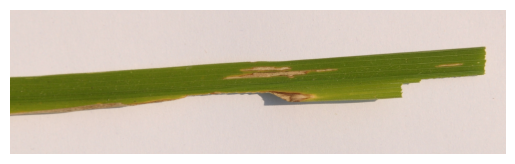

In [ ]:
# Paste your path inside the quotes below
my_path = "/content/drive/MyDrive/DeepRice_Project/rice_data/Bacterial leaf blight/DSC_0365.JPG"

# Run the prediction
predict_custom_image(my_path, model)